In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set(color_codes=True)
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.model_selection import train_test_split

In [33]:
data = pd.read_csv('raw.csv', sep=',',engine='python')
df = data
len(df)

5776

In [34]:
data_new = df.dropna(subset=['ASH','INSUL','TAAV','RH','dayav_ta','dayav_rh','MET','TRAV'])
print(len(data_new))
data_new.to_csv('raw_new.csv')
# get features and thermal sensation
y = data_new['ASH']
x = data_new[['INSUL','TAAV','RH','dayav_ta','dayav_rh','MET','TRAV']]
y = np.round(y)
#from sklearn import preprocessing
#lab_enc = preprocessing.LabelEncoder()
#encoded = lab_enc.fit_transform(y)
len(data_new)

3275


3275

In [35]:
# original
X_train1, X_test1, Y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=None)
np.shape(X_test1)

(328, 7)

In [36]:
def comfPMV(ta, tr, vel, rh, met, clo, wme):
    """
    returns [pmv, ppd]
    ta, air temperature (C)
    tr, mean radiant temperature (C)
    vel, relative air velocity (m/s)
    rh, relative humidity (%) Used only this way to input humidity level
    met, metabolic rate (met)
    clo, clothing (clo)
    wme, external work, normally around 0 (met)
    """

    pa = rh * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))

    icl = 0.155 * clo  # thermal insulation of the clothing in M2K/W
    m = met * 58.15  # metabolic rate in W/M2
    w = wme * 58.15  # external work in W/M2
    mw = m - w  # internal heat production in the human body
    if (icl <= 0.078):
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (0.645 * icl)

    # heat transf. coeff. by forced convection
    hcf = 12.1 * math.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)

    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = (308.7 - 0.028 * mw) + (p2 * math.pow(tra / 100, 4))
    xn = tcla / 100
    xf = tcla / 50
    eps = 0.00015

    n = 0
    while abs(xn - xf) > eps:
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(abs(100.0 * xf - taa), 0.25)
        if (hcf > hcn):
            hc = hcf
        else:
            hc = hcn
        xn = (p5 + p4 * hc - p2 * math.pow(xf, 4)) / (100 + p3 * hc)
        n += 1
        if (n > 150):
            print('Max iterations exceeded')
            return 1


    tcl = 100 * xn - 273

    # heat loss diff. through skin
    hl1 = 3.05 * 0.001 * (5733 - (6.99 * mw) - pa)
    # heat loss by sweating
    if mw > 58.15:
        hl2 = 0.42 * (mw - 58.15)
    else:
        hl2 = 0
    # latent respiration heat loss
    hl3 = 1.7 * 0.00001 * m * (5867 - pa)
    # dry respiration heat loss
    hl4 = 0.0014 * m * (34 - ta)
    # heat loss by radiation
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra / 100, 4))
    # heat loss by convection
    hl6 = fcl * hc * (tcl - ta)

    ts = 0.303 * math.exp(-0.036 * m) + 0.028
    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)
    ppd = 100.0 - 95.0 * math.exp(-0.03353 * pow(pmv, 4.0)
        - 0.2179 * pow(pmv, 2.0))

    r = []
    r.append(pmv)
    r.append(ppd)

    return r

In [37]:
#comfPMV(ta, tr, vel, rh, met, clo, wme)
pmvs = []
acc = 0
for i in range(len(X_test1)):
    temp = X_test1['TAAV'].iloc[i]
    humid = X_test1['RH'].iloc[i]
    clo = X_test1['INSUL'].iloc[i]
    met = X_test1['MET'].iloc[i]
    trav = X_test1['TRAV'].iloc[i]
    pmv = comfPMV(temp,trav,0.1,humid,met,clo,0)
    #if abs(pmv[0] - y.iloc[i]) < 0.5:
    pmv = np.round(pmv[0]).astype(int)
    if (pmv == y_test.iloc[i]):
        acc += 1
    pmvs.append(pmv)
#pmvs = np.round(pmvs).astype(int)
accuracy = acc/len(y_test)
print(accuracy)

0.4268292682926829


In [38]:
# testing
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [39]:
f1=f1_score(y_test, pmvs, average='weighted') 
r1=recall_score(y_test, pmvs, average='weighted') 
p1=precision_score(y_test,pmvs,average='weighted')
matrix_sensation = confusion_matrix(y_test, pmvs)
print(f1)
print(r1)
print(p1)

0.400440984648694
0.4268292682926829
0.40675512141634573


/Users/lusiliang93/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lusiliang93/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


328

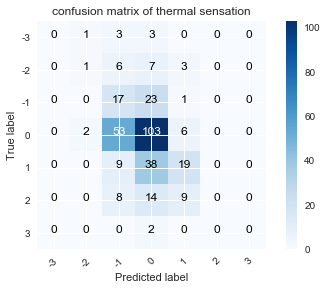

In [41]:
class_names = [-3,-2,-1,0,1,2,3]
plot_confusion_matrix(matrix_sensation,classes=class_names,
                      title='confusion matrix of thermal sensation')
np.sum(matrix_sensation)